---

# **Reinforcement Learning Black Jack** #

Kormishenkov Alexander, Ozerova Daria, Michael Kuznetsov


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns; sns.set()

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

NAME = 'Ozerova Daria'
ID_number = int('2070573')

random.seed(ID_number)
np.random.seed(ID_number)

## Jackblack rules:

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)


- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of _red_ (probability 1/3) or _black_ (probability
2/3).


- There are no aces or picture (face) cards in this game (no issues with usable aces!)


- At the start of the game both the player and the dealer draw one black
card (fully observed)


- Each turn the player may either **stick** or **hit**:
    - If the player hits then he draws another card from the deck
    - If the player sticks he receives no further cards and its turn ends


- The values of the player’s cards are added (if black card) or subtracted (if red
card)


- If the player’s sum exceeds 21, or becomes less than 1, then he “goes
bust” and loses the game, with a reward of -1


- If the player sticks then the dealer starts taking turns, same rules apply to him. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins, with a reward of 1; otherwise, the outcome – _win_ (reward 1),
_lose_ (reward -1), or _draw_ (reward 0) – is given by the player with the largest sum.

## Implementation of Jackblack environment

In [ ]:
class Jackblack():

    def __init__(self):
        dealer_score, _ = self.draw_card()
        player_score, _ = self.draw_card()
        self.state = {"dealer_score": dealer_score, "player_score": player_score}  # initial state
        self.actions = ("hit", "stick")

        init_state = self.state.copy()
        self.history = [init_state]  # game history, recording state and action of each step


    def step(self, action, verbose=False):
        #print('ENV STEP ACTION', action)
        self.history.append({"player": action})

        # player hits
        if action == "hit":
            value, colour = self.draw_card()
            self.state['player_score'] = self.compute_new_score(value, colour, self.state['player_score'])
            if verbose:
                print(f'Player draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append(new_state)

            if self.goes_bust(self.state['player_score']):
                # player goes bust
                reward = -1
                if verbose:
                    print('Player goes bust')
                    print('Player loses')
                return self.state, reward, True

            else:
                reward = 0
                return self.state, reward, False

        # player sticks
        else:
            if verbose:
                    print(f'Player stops')
            new_state = self.state.copy()
            self.history.append(new_state)

            state, reward = self.dealer_moves(verbose)
            return self.state, reward, True


    def draw_card(self):
        value = random.randint(1, 10)
        colour = np.random.choice(['red','black'], size = 1, p=(1/3,2/3))[0]
        return value, colour


    def goes_bust(self, score):
        return ((score > 21) or (score < 1))


    def compute_new_score(self, value, colour, current_score):
        if colour == "black":
            new_score = current_score + value
        elif colour == "red":
            new_score = current_score - value
        return new_score


    def dealer_moves(self, verbose=True):
        while self.state['dealer_score'] < 17:
            value, colour = self.draw_card()
            self.state['dealer_score'] = self.compute_new_score(value, colour, self.state['dealer_score'])
            if verbose:
                print(f'Dealer draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)


            if self.goes_bust(self.state['dealer_score']):
                # dealer goes bust, player wins
                if verbose:
                    print('Dealer goes bust')
                    print('Dealer loses')
                reward = 1
                return self.state, reward

        self.history.append({"dealer": "stick"})

        player_score = self.state['player_score']
        dealer_score = self.state['dealer_score']

        # score > 17 -> dealer sticks
        if verbose:
            print('Dealer stops')
        if dealer_score < player_score: # player wins
            reward = 1
            if verbose:
                print('Player wins')
            return self.state, reward
        if dealer_score == player_score: # draw
            reward = 0
            if verbose:
                print('Draw')
            return self.state, reward
        if dealer_score > player_score: # player loses
            reward = -1
            if verbose:
                print('Dealer wins')
            return self.state, reward


    def print_score(self):
        for player in self.state.items():
            print(player[0] + ': ' + str(player[1]))

In [ ]:
def plot_graph(policy, value, title):

    policy = policy.values

    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)

    matrix = pd.DataFrame(value, columns=dealer_showing, index=player_score)

    fig = plt.figure(figsize=(20,10))
    sns.set()
    ax = sns.heatmap(matrix, annot=policy, fmt="s", cmap='coolwarm', vmin=-2, vmax=3)
    ax.xaxis.tick_top()
    ax.set_title(title)

    plt.xlabel("Dealer")
    plt.ylabel("Player")

In [ ]:
env = Jackblack()
env.print_score()
env.step("hit", True)
env.print_score()
env.step("hit", True)
env.print_score()
env.step("stick", True)
env.print_score()

----------------
dealer_score: 5
player_score: 2
----------------
Player draws red 2
Player goes bust
Player loses
----------------
dealer_score: 5
player_score: 0
----------------
Player draws black 10
----------------
dealer_score: 5
player_score: 10
----------------
Player stops
Dealer draws black 10
Dealer draws black 10
Dealer goes bust
Dealer loses
----------------
dealer_score: 25
player_score: 10
----------------


## Monte-Carlo Control of Jackblack

Classical version of Monte Carlo algorithm for action-value functions in order to find a good policy to win over the dealer.

The $\epsilon$-greedy policy should be implemented such that:
$$ \epsilon = \frac{N_0}{N_0 + c_1}  $$

where $c_1$ is the number of times the state has been encountered so far.



In [ ]:
class MC_Control():

    def __init__(self, N_0=100, n_episodes=100, lr=None):

        self.actions = ("hit", "stick")
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior!)
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.lr = lr                    # The learning rate: "how much" the Q-function is updated at each step

        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init N to zeros
        self.policy = "random"          # arbitrarily init the MC learning with a random policy


    def learn_q_value_function(self):
        for i in range(self.n_episodes):
            episode = self.play_episode()
            # From the second episode onwards stating using the epsilon greedy policy
            self.policy = "e_greedy"
            for step in episode:
                state, action, reward, done = step
                #print('State', state)
                #print('Action', action)
                #print('Reward', reward)

                self.increment_counter(state, action) # increment state-action counter
                self.update_Q(state, action, reward)
        return self.Q


    def init_to_zeros(self):
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  # initialize to 0 the Q-values!

        return lookup_table


    def play_episode(self):

        env = Jackblack()                # init a game sequence
        state = env.state.copy()         # init state
        episode = []                     # list of the steps of the game sequence
        done = False
        while not done:
            # pick an action regarding the current state and policy
            #print('STATES', state)
            action = self.get_action(state)
            #print('ACTION', action)
            next_state, reward, done = deepcopy(env.step(action))
            step = (state, action, reward, done)  # store previous state
            state = next_state
            episode.append(step)

        return episode


    def update_Q(self, state, action, total_reward):
        lookup_state = tuple(state.values())
        alpha = (1 / self.get_state_action_counter(state, action))
        self.Q[lookup_state][action] +=  alpha* (total_reward - self.Q[lookup_state][action])


    def increment_counter(self, state, action):
        lookup_state = tuple(state.values())
        self.N[lookup_state][action] += 1


    def random_policy(self):
        action = random.choice(self.actions)
        return action


    def e_greedy_policy(self, state):
        threshold = self.N_0/(self.N_0 + self.get_state_counter(state))
        if threshold > random.uniform(0, 1):
            action = random.choice(self.actions)
        else:
            action = self.get_action_w_max_value(state)
        return action


    def get_action(self, state):
        if self.policy == "random":
            action = self.random_policy()
        if self.policy == "e_greedy":
            action = self.e_greedy_policy(state)
        return action


    def get_action_w_max_value(self, state):
        lookup_state = tuple(state.values())
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get)
            return action


    def get_state_counter(self, state):
        try:
            counter = np.sum(list(self.N[state].values()))
        except TypeError:
            lookup_state = tuple(state.values())
            counter = np.sum(list(self.N[lookup_state].values()))

        return counter


    def get_state_action_counter(self, state, action):
        try:
            counter = self.N[state][action]
        except TypeError:
            lookup_state = tuple(state.values())
            counter = self.N[lookup_state][action]

        return counter


    def optimal_policy(self):
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
            max_Q[states[i][1]-1][states[i][0]-1] = max(self.Q[states[i]].values())
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot(index="player_score", columns="dealer_showing", values="best_action")

        return max_Q, df_pivot


def plot_table(table):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(projection = '3d')
    #ax = fig.gca(projection='3d')
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)
    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, table, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Customize plot
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Value function', fontsize=16)
    plt.xticks(np.arange(1, 11))
    plt.yticks(np.arange(1, 22))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [ ]:
mc = MC_Control(n_episodes=50_000)
mc.learn_q_value_function();
mcvalue, mcpol = mc.optimal_policy()

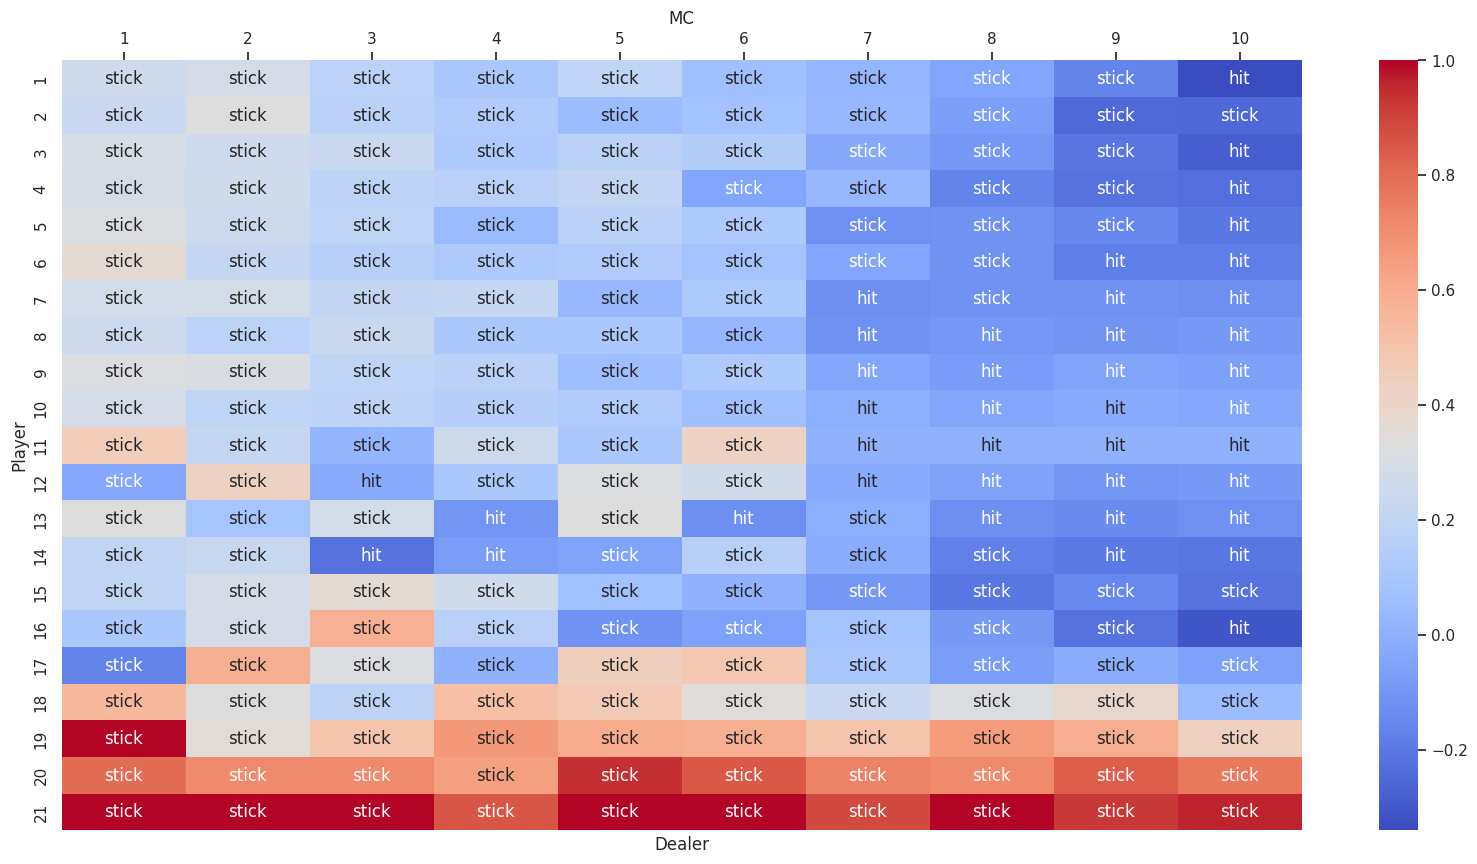

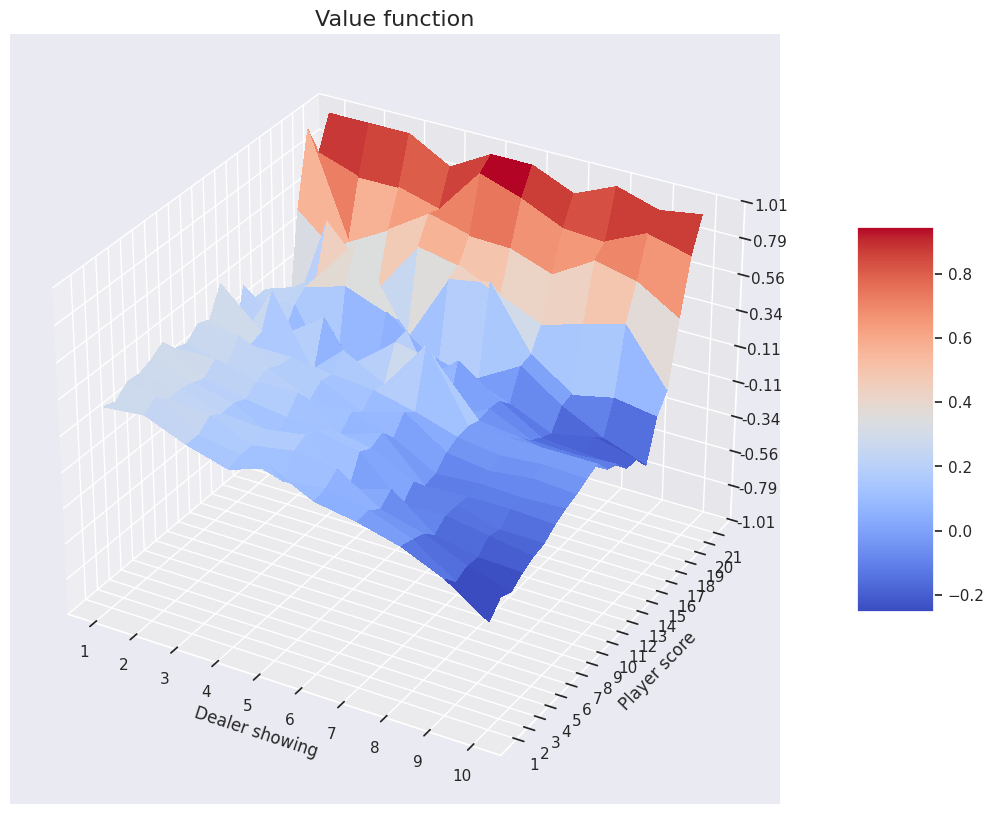

In [ ]:
plot_graph(mcpol, mcvalue, "MC")
plot_table(mcvalue)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from torch.distributions import Distribution
Distribution.set_default_validate_args(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm


class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.loss = []

    def clear_memory(self):
        self.actions.clear()
        self.states.clear()
        self.logprobs.clear()
        self.rewards.clear()
        self.is_terminals.clear()
        self.loss.clear()

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        state = state.float().to(device)
        #print('states got', state)
        action_probs = self.actor(state)
        action_probs = torch.clamp(action_probs, min=1e-6, max=1.0)  # Clamp to avoid invalid values
        value = self.critic(state)
        return action_probs, value

class PPO:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, clip_epsilon=0.2):
        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.memory = Memory()
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon

    def select_action(self, state):
        #print('SELECT ACTION ', state, torch.from_numpy(state))
        state_tensor = torch.FloatTensor(state).to(device)
        action_probs, _ = self.policy(state_tensor)
        #print('action_probs', action_probs)
        #print()
        dist = Categorical(action_probs)
        action = dist.sample()
        self.memory.states.append(state_tensor)
        self.memory.actions.append(action)
        self.memory.logprobs.append(dist.log_prob(action))
        return action.item()

    def update(self):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + self.gamma * discounted_reward
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        #print(rewards.std())
        #print()
        rewards = (rewards - rewards.mean()) / (torch.var_mean(rewards, dim=-1, unbiased=False, keepdim=True)[-1] + 1e-8)  # Prevent division by zero

        old_states = torch.stack(self.memory.states).detach().to(device)
        old_actions = torch.tensor(self.memory.actions).detach().to(device)
        old_logprobs = torch.tensor(self.memory.logprobs).detach().to(device)

        for _ in range(5):  # Number of PPO updates
            action_probs, state_values = self.policy(old_states)
            action_probs = torch.clamp(action_probs, min=1e-6, max=1.0)
            dist = Categorical(action_probs)
            logprobs = dist.log_prob(old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach().squeeze()

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            loss = -torch.min(surr1, surr2).mean() + 0.5 * (rewards - state_values.squeeze()).pow(2).mean()
            self.memory.loss.append(loss)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        #self.memory.clear_memory()


# Training the PPO agent
def train_ppo(env, ppo_agent, max_episodes=1000):
    total_reward = 0
    for episode in tqdm(range(max_episodes)):
        env = Jackblack()                # init a game sequence
        #state = env.state.copy()
        state = np.array(list(env.state.values()), dtype=np.float32)
        #print()
        #print('START STATES', state)
        done = False
        while not done:
            action = ppo_agent.select_action(state)
            #print('ACTION', action, env.actions[1 - action])

            next_state, reward, done = deepcopy(env.step(env.actions[action])) #
            step = (state, action, reward, done)  # store previous state #
            #state = next_state #
            #episode.append(step) #

            #next_state, reward, done = env.step(env.actions[action])
            #print('NEXT STATE', next_state, 'REWARD', reward)
            next_state = np.array(list(next_state.values()), dtype=np.float32)

            ppo_agent.memory.rewards.append(reward)
            ppo_agent.memory.is_terminals.append(done)

            state = next_state
            total_reward += reward

            ppo_agent.update()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")
            total_reward = 0
    return ppo_agent

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize environment and PPO agent
env = Jackblack()
state_dim = 2  # "dealer_score" and "player_score"
action_dim = 2  # "hit" or "stick"
ppo_agent = PPO(state_dim, action_dim)

# Train the agent
ppo_agent = train_ppo(env, ppo_agent, max_episodes=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 100, Total Reward: 7
Episode 200, Total Reward: 5
Episode 300, Total Reward: 6
Episode 400, Total Reward: 3
Episode 500, Total Reward: 18
Episode 600, Total Reward: 0
Episode 700, Total Reward: 14
Episode 800, Total Reward: 16
Episode 900, Total Reward: -2
Episode 1000, Total Reward: 0
Episode 1100, Total Reward: 6
Episode 1200, Total Reward: 2
Episode 1300, Total Reward: 2
Episode 1400, Total Reward: 14
Episode 1500, Total Reward: -20
Episode 1600, Total Reward: -9
Episode 1700, Total Reward: 4
Episode 1800, Total Reward: -16
Episode 1900, Total Reward: 20
Episode 2000, Total Reward: 10
Episode 2100, Total Reward: 8
Episode 2200, Total Reward: -2
Episode 2300, Total Reward: 14
Episode 2400, Total Reward: -12
Episode 2500, Total Reward: -6
Episode 2600, Total Reward: 7
Episode 2700, Total Reward: -2
Episode 2800, Total Reward: 18
Episode 2900, Total Reward: 2
Episode 3000, Total Reward: -12


In [ ]:
def plot_graph(policy, value, title):

    policy = policy.values

    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)

    matrix = pd.DataFrame(value, columns=dealer_showing, index=player_score)

    fig = plt.figure(figsize=(20,10))
    sns.set()
    ax = sns.heatmap(matrix, annot=policy, fmt="s", cmap='coolwarm', vmin=-10, vmax=10)
    ax.xaxis.tick_top()
    ax.set_title(title)

    plt.xlabel("Dealer")
    plt.ylabel("Player")

  0%|          | 0/210 [00:00<?, ?it/s]

[1.0, 1.0]
0.0 0.0
[1.0, 2.0]
1.0 0.0
[1.0, 3.0]
2.0 0.0
[1.0, 4.0]
3.0 0.0
[1.0, 5.0]
4.0 0.0
[1.0, 6.0]
5.0 0.0
[1.0, 7.0]
6.0 0.0
[1.0, 8.0]
7.0 0.0
[1.0, 9.0]
8.0 0.0
[1.0, 10.0]
9.0 0.0
[1.0, 11.0]
10.0 0.0
[1.0, 12.0]
11.0 0.0
[1.0, 13.0]
12.0 0.0
[1.0, 14.0]
13.0 0.0
[1.0, 15.0]
14.0 0.0
[1.0, 16.0]
15.0 0.0
[1.0, 17.0]
16.0 0.0
[1.0, 18.0]
17.0 0.0
[1.0, 19.0]
18.0 0.0
[1.0, 20.0]
19.0 0.0
[1.0, 21.0]
20.0 0.0
[2.0, 1.0]
0.0 1.0
[2.0, 2.0]
1.0 1.0
[2.0, 3.0]
2.0 1.0
[2.0, 4.0]
3.0 1.0
[2.0, 5.0]
4.0 1.0
[2.0, 6.0]
5.0 1.0
[2.0, 7.0]
6.0 1.0
[2.0, 8.0]
7.0 1.0
[2.0, 9.0]
8.0 1.0
[2.0, 10.0]
9.0 1.0
[2.0, 11.0]
10.0 1.0
[2.0, 12.0]
11.0 1.0
[2.0, 13.0]
12.0 1.0
[2.0, 14.0]
13.0 1.0
[2.0, 15.0]
14.0 1.0
[2.0, 16.0]
15.0 1.0
[2.0, 17.0]
16.0 1.0
[2.0, 18.0]
17.0 1.0
[2.0, 19.0]
18.0 1.0
[2.0, 20.0]
19.0 1.0
[2.0, 21.0]
20.0 1.0
[3.0, 1.0]
0.0 2.0
[3.0, 2.0]
1.0 2.0
[3.0, 3.0]
2.0 2.0
[3.0, 4.0]
3.0 2.0
[3.0, 5.0]
4.0 2.0
[3.0, 6.0]
5.0 2.0
[3.0, 7.0]
6.0 2.0
[3.0, 8.0]
7.0 2.0
[3.0

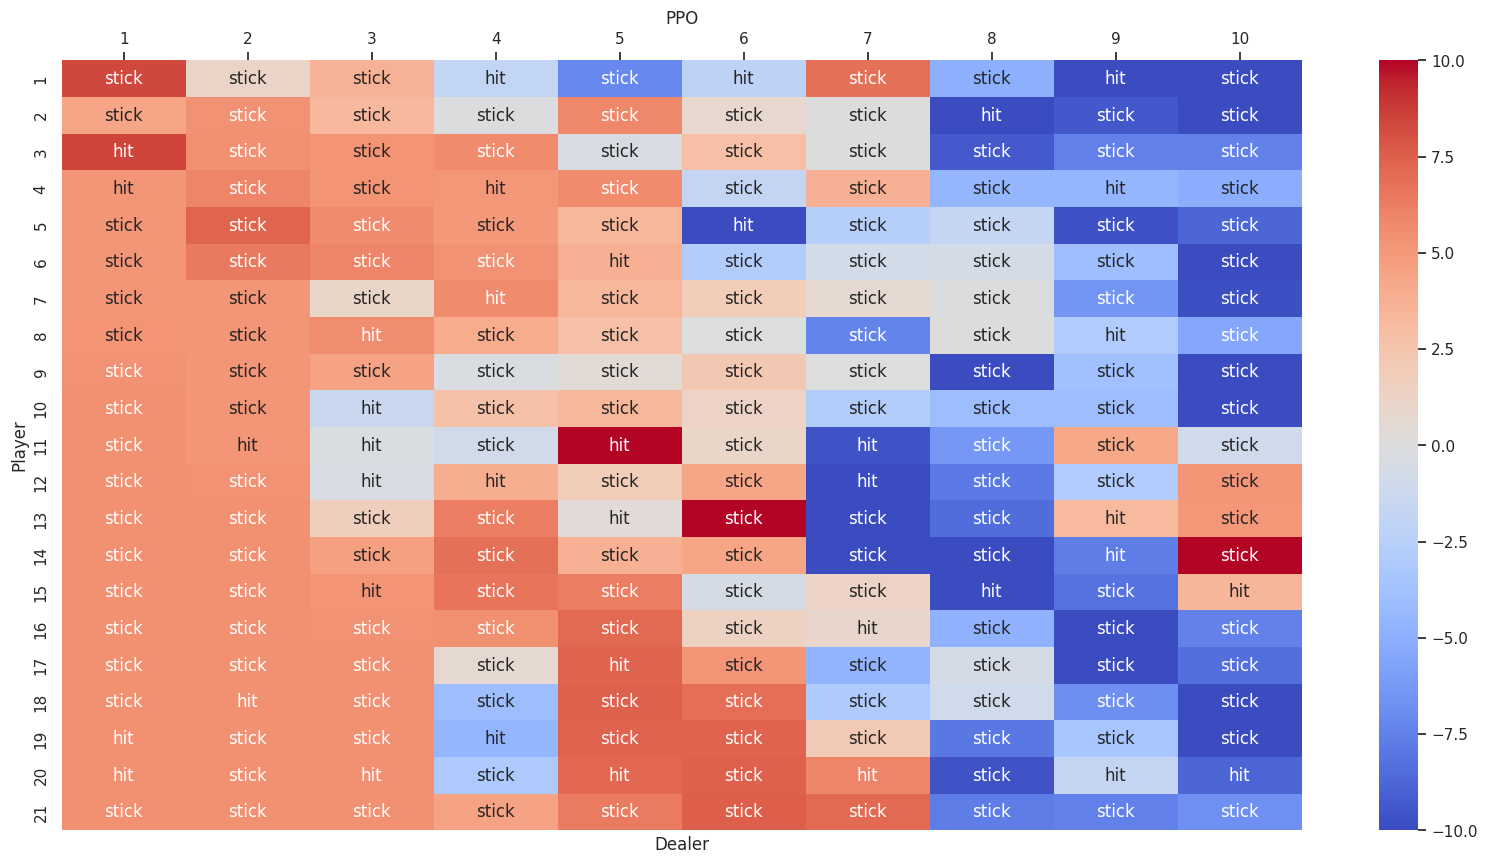

In [ ]:
def optimal_policy(ppo_agent):
    env = Jackblack()
    best_policy = np.ndarray(shape=(21, 10))
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    states = [[float(i), float(j)] for i in range(1, 11) for j in range(1, 22)]
    for i in tqdm(range(len(states))):
        action = ppo_agent.select_action(states[i])
        best_action = env.actions[action]

        print(states[i])
        print(states[i][1]-1, states[i][0]-1)
        critic_val = ppo_agent.policy( torch.FloatTensor(states[i]).to(device))[1].item()
        best_policy[int(states[i][1]-1)][int(states[i][0]-1)] = critic_val  #np.log1p(abs(critic_val)) * np.sign(critic_val)
        df.loc[i] = (states[i][0], states[i][1], best_action)
    df_pivot = df.pivot(index="player_score", columns="dealer_showing", values="best_action")

    return df_pivot, best_policy

df_pivot, best_policy = optimal_policy(ppo_agent)
plot_graph(df_pivot, best_policy, "PPO")

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def plot_loss_changes(losses, title="", xlabel="Episode", ylabel="Loss"):

    losses_np = np.array([loss.item() for loss in losses])
    import pandas as pd
    df = pd.DataFrame({
        xlabel: range(1, len(losses_np) + 1),
        ylabel: losses_np
    })
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=xlabel, y=ylabel)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


example_losses = ppo_agent.memory.loss
plot_loss_changes(example_losses,
                  title="Example Loss Changes During Training",
                  xlabel="Episode Number",
                  ylabel="Training Loss")

Cumulative rewards example: [-1 -2 -2 -1 -1 -2 -2 -3 -3 -4]


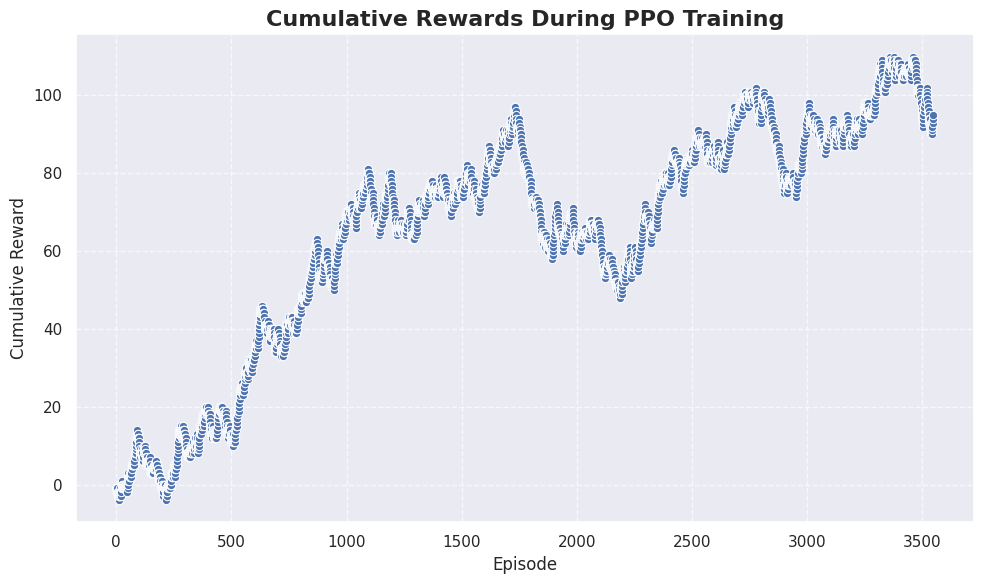

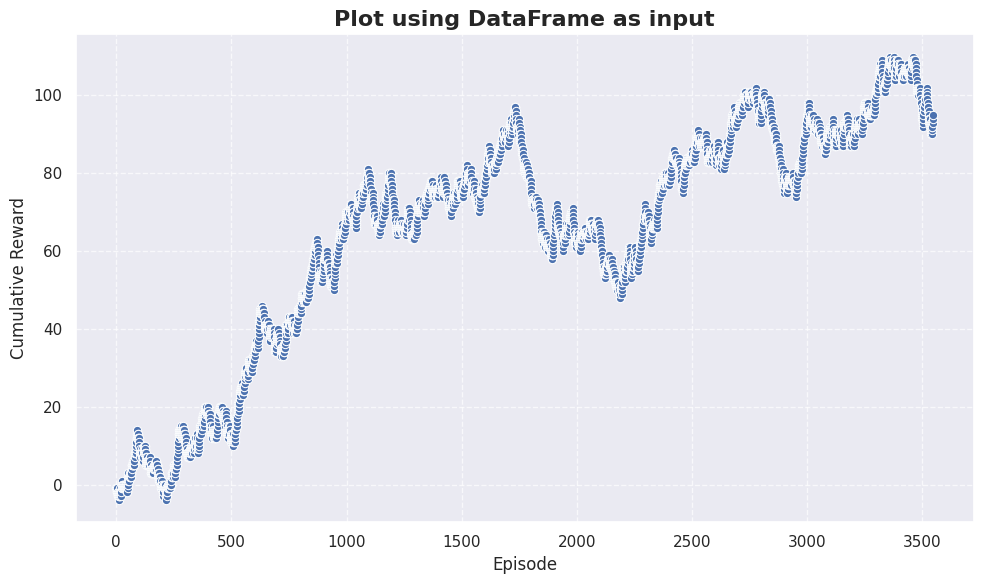

In [ ]:
def calculate_cumulative_rewards(rewards_array):
    if not isinstance(rewards_array, (np.ndarray, list)):
        print("Invalid input: rewards_array must be a list or numpy array.")
        return None

    if isinstance(rewards_array,list):
         rewards_array = np.array(rewards_array)

    if rewards_array.ndim !=1:
        print("Invalid input: rewards_array must be 1 dimensional array or list.")
        return None

    cumulative_rewards = np.cumsum(rewards_array)
    return cumulative_rewards


def plot_cumulative_rewards(rewards_data, title="Cumulative Rewards During PPO Training"):
    if isinstance(rewards_data,(np.ndarray, list)):
        if isinstance(rewards_data,list):
            rewards_data = np.array(rewards_data)

        if rewards_data.ndim !=1:
            print("Data is not 1 dimentional, can not convert to DataFrame")
            return

        cumulative_rewards = calculate_cumulative_rewards(rewards_data)
        if cumulative_rewards is None:
             return
        df = pd.DataFrame({'Episode': np.arange(1, len(cumulative_rewards) + 1), 'Cumulative Reward': cumulative_rewards})
    elif isinstance(rewards_data, pd.DataFrame):
        df = rewards_data.copy()
        if not all(col in df.columns for col in ['Episode', 'Cumulative Reward']):
            print('DataFrame need to contain columns: "Episode", "Cumulative Reward"')
            return
    else:
        print("Type of data is not supported, provide numpy array, list or Pandas DataFrame")
        return


    sns.set_theme(style="darkgrid")  # Set dark grid style

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size
    sns.lineplot(x='Episode', y='Cumulative Reward', data=df, marker='o', ax=ax)  # Add markers
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Cumulative Reward', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    fig.tight_layout() #adjust padding

    plt.show()


episode_rewards = np.array(ppo_agent.memory.rewards)
cumulative_rewards = calculate_cumulative_rewards(episode_rewards)

if cumulative_rewards is not None:
    print("Cumulative rewards example:", cumulative_rewards[:10]) #print just first 10 for demonstration
    plot_cumulative_rewards(episode_rewards)

    df_example = pd.DataFrame({'Episode': np.arange(1, len(cumulative_rewards) + 1), 'Cumulative Reward': cumulative_rewards})
    plot_cumulative_rewards(df_example,"Plot using DataFrame as input")